In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
import matplotlib.lines as mlines
import os
import h5py
from tqdm import tqdm
from prior_distributions import *
from astropy.cosmology import Planck18 
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
from sklearn.neighbors import KernelDensity

In [2]:
# set same font value for all the figures
font_value = 18
plt.rcParams.update({'font.size': font_value})

In [3]:
# read Signals_*.txt files where you get the samples of the instrinsic distributions
signals_PopI = pd.read_csv('../GWFish_results/pop12_10yr_v2/fiducial/10yr/Signals_ET_pop12_Tobs10yr.txt', delimiter = ' ')

In [4]:
signals_PopI.keys()

Index(['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 'theta_jn',
       'psi', 'geocent_time', 'phase', 'redshift', 'ET_SNR'],
      dtype='object')

In [5]:
# from this you evalaute the detection probability of the population

# we consider p_det = 1 if SNR > 12 and count 
count = (signals_PopI['ET_SNR']>12).sum()

print("Number of detected instances:", count)

p_det_PopI = count/(signals_PopI['ET_SNR']>0).sum()

print("p_det PopI",p_det_PopI)

Number of detected instances: 380316
p_det PopI 0.4285912304209213


In [6]:
# take the fiducial balanced case for Pop. III
signals_PopIII = pd.read_csv('../GWFish_results/pop3/fiducial/1500yr/Signals_ET_pop3_LOG1_Tobs1500yr.txt', delimiter = ' ')

In [7]:
signals_PopIII

,mass_1,mass_2,luminosity_distance,dec,ra,theta_jn,psi,geocent_time,phase,redshift,ET_SNR
0,47.079554,14.247890,182.966031,0.380068,2.772293,0.960287,4.949145,9.988566e+09,0.585489,0.04008,1316.879216
1,37.130981,21.944097,182.966031,0.351035,1.001969,1.365661,2.139081,2.959524e+10,4.873911,0.04008,948.978118
2,29.558710,21.977109,182.966031,0.154965,2.457249,1.461163,0.547113,4.253304e+09,0.713802,0.04008,702.118867
3,23.635069,21.842772,182.966031,-0.358748,0.355849,0.878850,0.732387,3.229147e+10,4.852947,0.04008,2222.334336
4,32.857591,21.075445,579.738957,-0.095371,1.700208,2.117404,2.506298,2.762645e+10,0.314634,0.12024,532.988470
...,...,...,...,...,...,...,...,...,...,...,...
1037384,1164.181747,796.086858,343267.750232,1.285166,5.772638,1.063712,1.161678,1.469462e+10,3.162423,28.81764,6.592594
1037385,1062.263317,525.683314,345346.032257,0.131181,4.558616,1.735183,4.819860,2.569837e+10,1.784018,28.97796,3.182183
1037386,1020.627528,967.029633,345346.032257,-0.051452,2.120883,2.251882,1.661304,2.620451e+10,2.847241,28.97796,8.100211
1037387,1011.523068,967.386927,346385.404136,0.170085,0.434587,2.743150,0.890689,1.850984e+10,2.311529,29.05812,16.705315


In [8]:
signals_PopIII.keys()

Index(['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 'theta_jn',
       'psi', 'geocent_time', 'phase', 'redshift', 'ET_SNR'],
      dtype='object')

In [9]:
# from this you evalaute the detection probability of the population
count_III = (signals_PopIII['ET_SNR']>12).sum()

print("Number of detected instances:", count_III)

p_det_PopIII = count_III/(signals_PopIII['ET_SNR']>0).sum()

print("p_det PopIII",p_det_PopIII)

Number of detected instances: 569616
p_det PopIII 0.5490862154890789


In [10]:
# Columns to keep
columns_to_keep = ['mass_1', 'mass_2', 'luminosity_distance']

# Select only the columns you want to keep
data_PopI = signals_PopI.loc[:, columns_to_keep]

print(data_PopI )

# Select only the columns you want to keep
data_PopIII = signals_PopIII.loc[:, columns_to_keep]

print(data_PopIII)

            mass_1      mass_2  luminosity_distance
0        10.189037    8.013053           171.758316
1         8.418924    7.147173           171.758316
2         7.379989    6.226825           171.758316
3         8.219750    8.052090           171.758316
4         7.915831    6.233093           171.758316
...            ...         ...                  ...
887358  415.070868  413.802656        163032.604216
887359  602.965412  561.024244        163968.483679
887360  688.154481  495.148975        163968.483679
887361  478.937090  445.977661        163968.483679
887362  601.212244  409.338326        163968.483679

[887363 rows x 3 columns]
              mass_1      mass_2  luminosity_distance
0          47.079554   14.247890           182.966031
1          37.130981   21.944097           182.966031
2          29.558710   21.977109           182.966031
3          23.635069   21.842772           182.966031
4          32.857591   21.075445           579.738957
...              ...     

In [11]:
# corner plot arguments 
CORNER_KWARGS = dict(
    smooth = 0.1, # smooths out contours. 
    plot_datapoints = False, # choose if you want datapoints
    label_kwargs = dict(fontsize = font_value), # font size for labels
    #show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = font_value), # font size for title
    plot_density = True,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    #max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".3f",
    axes_scale='log',
    bins = 40
    )

KDE evaluated


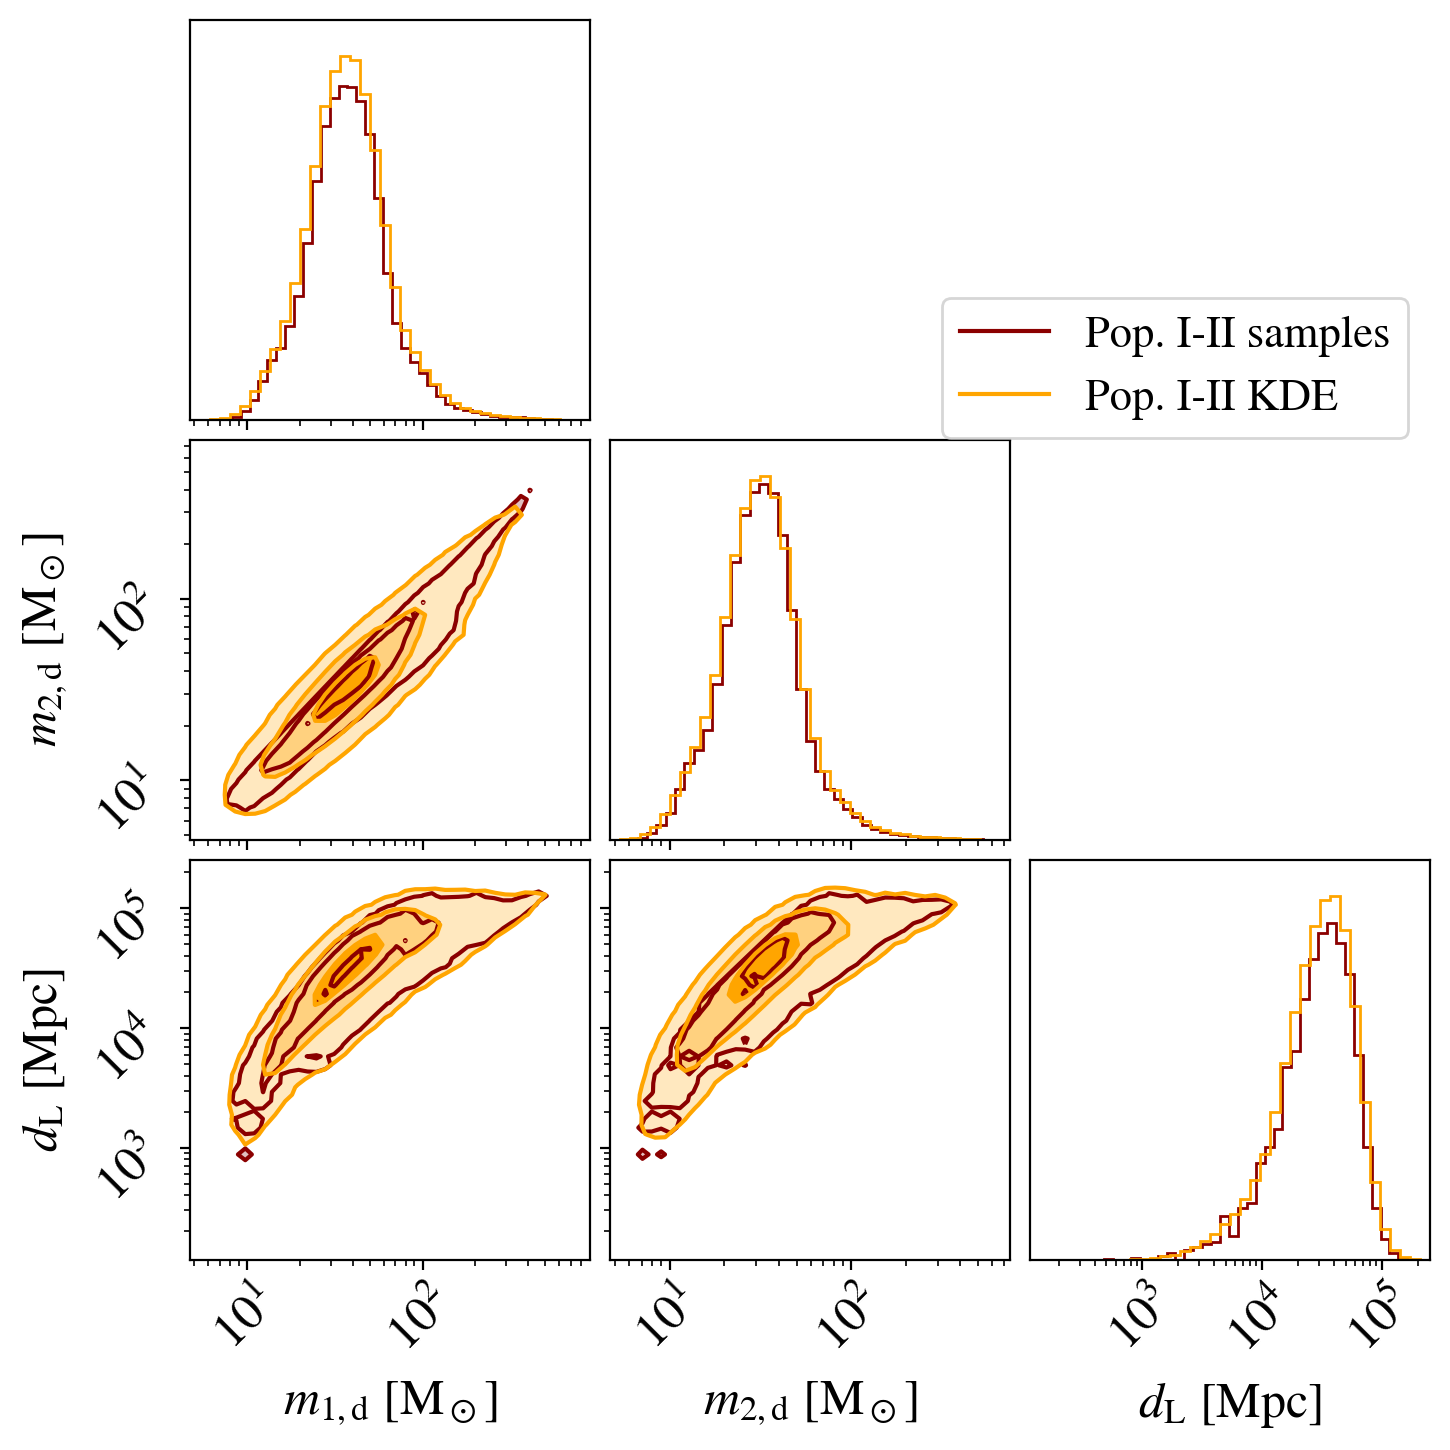

In [12]:
# Initialize KDE

## log x
kde_PopI = KernelDensity(kernel='gaussian', bandwidth='scott',#algorithm='ball_tree',
                         #algorithm='kd_tree', #
                         rtol = 50
                        #atol = 5
                        ).fit(np.log(data_PopI))

## x
#kde_PopI = KernelDensity(kernel='gaussian', bandwidth=1,#'scott',
#                         algorithm='ball_tree', atol = 1e-200).fit(data_PopI)

print('KDE evaluated')

# Plot corner plot
figure = corner.corner(data_PopI,
                       **CORNER_KWARGS,
                       labels=[r'$m_{1,\mathrm{d}}$ [M$_\odot$]', r'$m_{2,\mathrm{d}}$ [M$_\odot$]', r'$d_{\mathrm{L}}$ [Mpc]'], 
                       color='darkred')

## log x
r_data_resampled = np.exp(kde_PopI.sample(887363,
    #11397, 
    random_state = 42))


##  x
#r_data_resampled = kde_PopI.sample(887363,
    #11397, 
#    random_state = 42)

corner.corner(r_data_resampled,
                       **CORNER_KWARGS, 
                       color='orange', fig = figure)

red_line = mlines.Line2D([], [], color='darkred', label='Pop. I-II samples')
black_line = mlines.Line2D([], [], color='orange', label='Pop. I-II KDE')
plt.legend(handles=[red_line, black_line], bbox_to_anchor=(0., 2.0, 1., .0), loc=4, fontsize = 16)
for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=font_value)

plt.show()

KDE evaluated


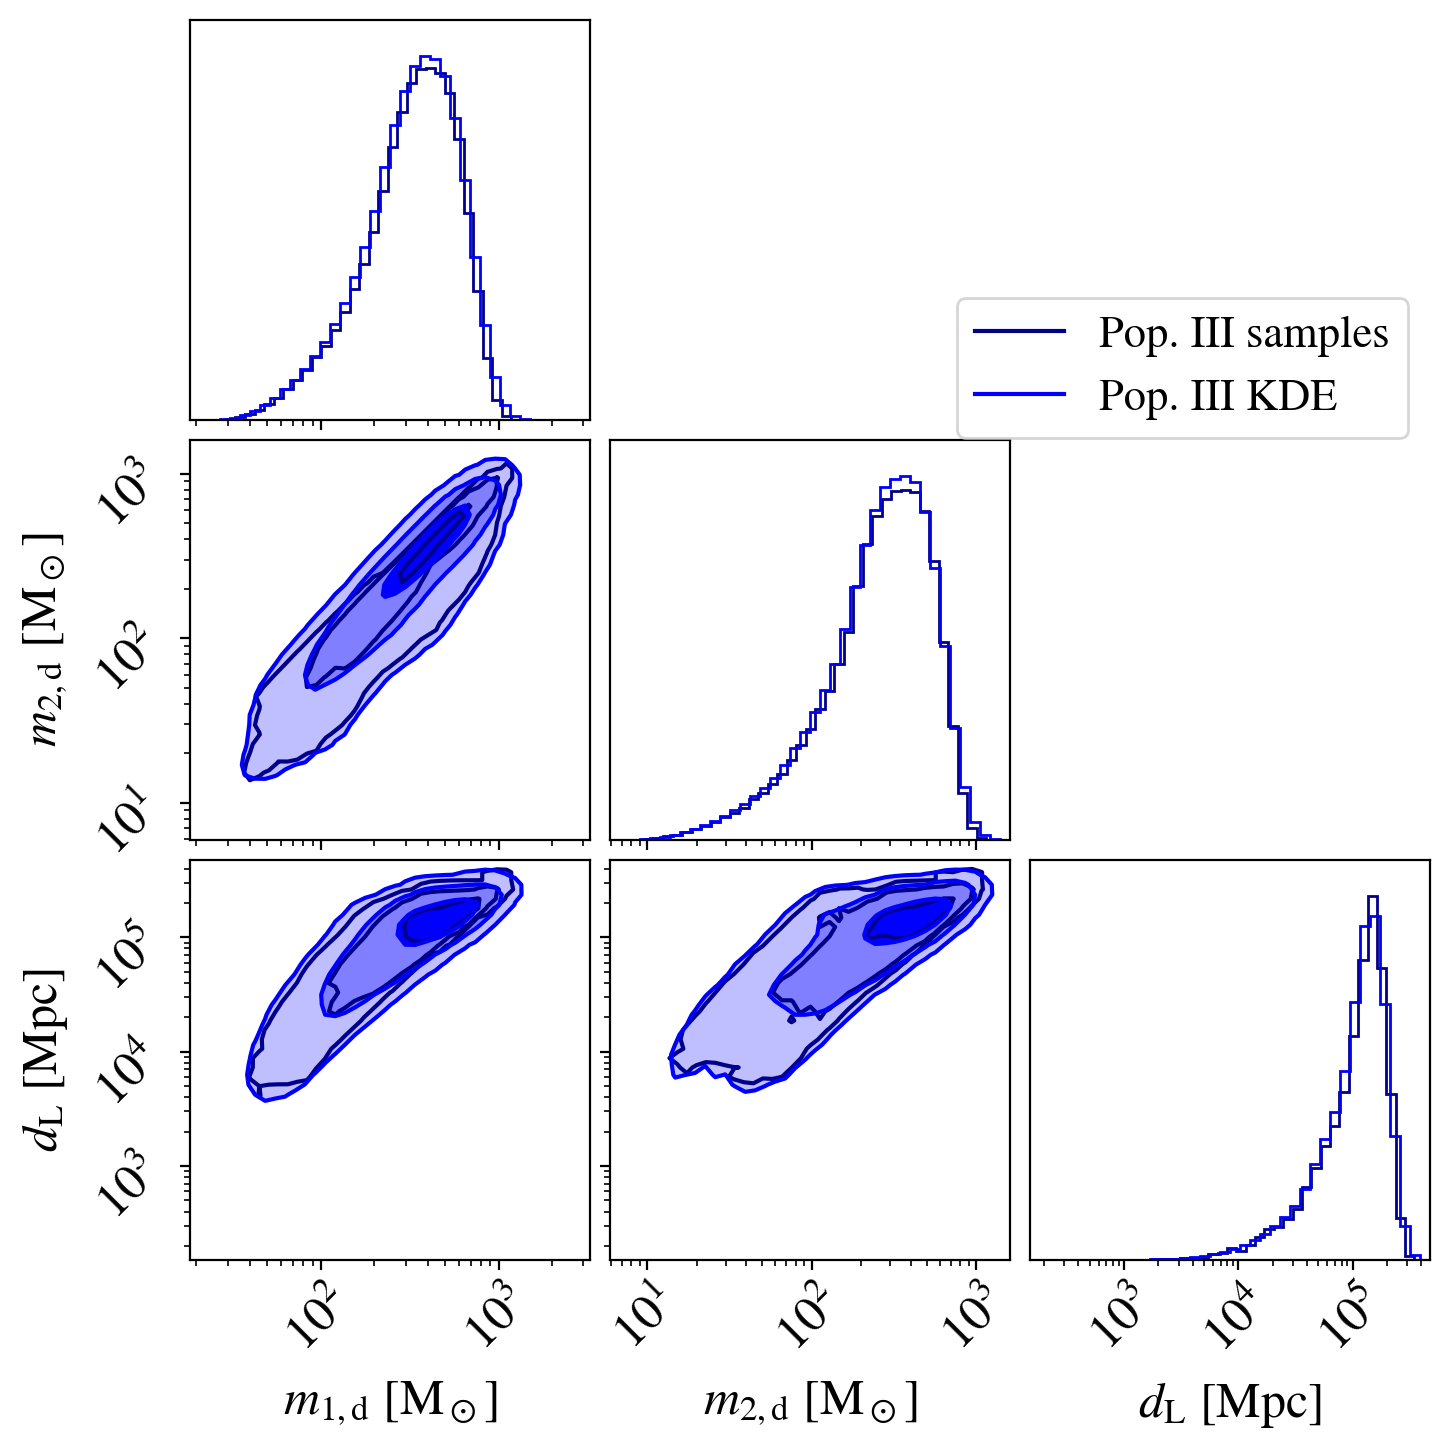

In [13]:
# Initialize KDE

## log x
kde_PopIII = KernelDensity(kernel='gaussian', bandwidth='scott', #algorithm='ball_tree',
                          #algorithm='ball_tree', 
                            rtol = 50
                          #atol = 5
                          ).fit(np.log(data_PopIII))

## x
#kde_PopIII = KernelDensity(kernel='gaussian', bandwidth=1,#'scott',
#                          algorithm='ball_tree', atol = 1e-200).fit(data_PopIII)


print('KDE evaluated')

# Plot corner plot
figure = corner.corner(data_PopIII,
                       **CORNER_KWARGS,
                       labels=[r'$m_{1,\mathrm{d}}$ [M$_\odot$]', r'$m_{2,\mathrm{d}}$ [M$_\odot$]', r'$d_{\mathrm{L}}$ [Mpc]'], 
                       color='darkblue')

## log x
r_data_resampled = np.exp(kde_PopIII.sample(1037389,
    #11397,
                                            random_state = 42))

## x
#r_data_resampled = kde_PopIII.sample(1037389,
    #11397,
#                                            random_state = 42)

corner.corner(r_data_resampled,
                       **CORNER_KWARGS, 
                       color='blue', fig = figure)

red_line = mlines.Line2D([], [], color='darkblue', label='Pop. III samples')
black_line = mlines.Line2D([], [], color='blue', label='Pop. III KDE')
plt.legend(handles=[red_line, black_line], bbox_to_anchor=(0., 2.0, 1., .0), loc=4, fontsize = 16)
for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=font_value)

plt.show()

In [14]:
# define the prior you adopted for the parameter estimation of the single detection
# you can take them from the ResamplingWithPriors notebook

# detector-frame primary mass
min_m1 = 0
max_m1 = 1e5

# detector-frame secondary mass
min_m2 = 0

# luminosity distance - limits are put in redshift
min_dl = 0
min_z = 1e-4
max_z = 1e3

zz = np.linspace(min_z, max_z, 1000)
dd = Planck18.luminosity_distance(zz).value

norm_factor = norm_factor_distance_prior(min_z, max_z)

def UniformInComovingVolume(z):
    # exaclty the same as Ulyana's
    dVc_dz = 4*np.pi*cosmo.differential_comoving_volume(z).value
    dl = cosmo.luminosity_distance(z).value
    dz_ddl = (dl / (1 + z) + (const.c.value / 1000) * (1 + z) / (cosmo.H(0).value * cosmo.efunc(z)))**(-1)
    dVc_ddl = dVc_dz*dz_ddl*(1/(1+z))
    return dVc_ddl

In [15]:
# priors can be easily added in post processing
# define the priors of each model:
# 1. the same you used in ML 
# 2. the instrinsic one, in imbalanced cases clearly
# 3. without priors at all on the model

In [16]:
skip = False

In [17]:
if skip == False:
    # load posterior samples of Pop. I-II detections 
    path_to_file = '../test_catalogs_v1/test_cat_Pop.I_fiducial_0.3_10yr_WithPhysicalPriors.h5'
    f1_PopI = h5py.File(path_to_file,'r')  
    
    num_sam = len(np.array(f1_PopI['instance_0']['samples'][0]))
    print('number of samples per each detection = ', num_sam)
    
    #index_subsample = np.arange(len(f1_PopI.keys()))
    #index_subsample = np.arange(10_000, 11_300)
    #index_subsample = np.random.choice(np.arange(len(f1_PopI.keys())),3420)
    # the same used in XGBoost analysis 
    index_subsample = np.loadtxt('../clf_plots_v9/indices_to_use_Pop.I_fiducial_0.3_True.txt').astype(int)
    print('detections = ', index_subsample)
    print('number of detections = ', len(index_subsample))
    
    bayes_ratios_nopriors_PopI = []
    medians_arr_PopI = np.zeros((len(index_subsample),3))
    
    # You have everything the evaluate the bayes ratio 
    for i_c, i in (enumerate(tqdm(index_subsample, disable = False))):
        #print('detection = ', i)
        #ind_test = np.random.choice(np.arange(num_sam),200)
        X_test = np.transpose(f1_PopI['instance_'+str(i)]['samples'])#[ind_test,:]
        ## log x        
        X_test_dict_log = {'mass_1': np.log(X_test[:,0]), 
                      'mass_2': np.log(X_test[:,1]), 
                      'luminosity_distance': np.log(X_test[:,2])}
        X_test_kde_log = pd.DataFrame(X_test_dict_log)
    
        #print(X_test.shape)

        ## x
        #X_test_dict = {'mass_1': X_test[:,0], 
        #      'mass_2': X_test[:,1], 
        #      'luminosity_distance': X_test[:,2]}
        #X_test_kde = pd.DataFrame(X_test_dict)
        #print(X_test_kde)
        
        priors_array = [
            uniform_pdf(X_test[:,0], min_m1, max_m1),
            uniform_pdf(X_test[:,1], min_m2, X_test[:,0]),
            uniform_in_differential_comoving_volume_pdf(
                X_test[:,2], 
                min_z, 
                max_z, 
                np.interp(X_test[:,2], 
                          dd, 
                          zz), norm_factor)] 
    
        priors_prod = np.prod(priors_array, axis = 0)
        #print('priors_prod = ', priors_prod)
        
        ## log x
        kde_result_PopIII = kde_PopIII.score_samples(X_test_kde_log)
        ## x
        #kde_result_PopIII = kde_PopIII.score_samples(X_test_kde)

        posterior_ratio_PopIII = np.log(np.sum(
                    np.exp(kde_result_PopIII-np.log(priors_prod)
                          )))
        #print('posterior_ratio_PopIII = ', posterior_ratio_PopIII)

        ## log x
        kde_result_PopI = kde_PopI.score_samples(X_test_kde_log)
        ##  x
        #kde_result_PopI = kde_PopI.score_samples(X_test_kde)
        
        posterior_ratio_PopI = np.log(np.sum(
                    np.exp(kde_result_PopI-np.log(priors_prod)
                          )))
        #print('posterior_ratio_PopI = ', posterior_ratio_PopI)
    
        bayes_ratio_nopriors = np.log(p_det_PopI) - np.log(p_det_PopIII) + posterior_ratio_PopIII - posterior_ratio_PopI

        #print('bayes_ratio_nopriors = ', bayes_ratio_nopriors)
        bayes_ratios_nopriors_PopI.append(bayes_ratio_nopriors)
        medians = np.median(X_test, axis = 0)
        medians_arr_PopI[i_c,:] = medians

number of samples per each detection =  1000
detections =  [    1     4     5 ... 11389 11393 11395]
number of detections =  3420


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3420/3420 [08:09<00:00,  6.99it/s]


In [18]:
if skip == False:
    np.savetxt('bayes_ratio_PopI_rtol_inv_log.txt', np.transpose([medians_arr_PopI[:,0],medians_arr_PopI[:,1],medians_arr_PopI[:,2], bayes_ratios_nopriors_PopI]),
          header = 'med_mass_1 med_mass_2 med_lum_dist log_D_AB', comments = '')
elif skip == True:
    medians_arr_PopI = np.transpose(np.loadtxt('bayes_ratio_PopI_rtol_inv.txt', skiprows = 1, unpack = True, usecols = [0,1,2]))
    bayes_ratios_nopriors_PopI = np.loadtxt('bayes_ratio_PopI_rtol_inv.txt', skiprows = 1, unpack = True, usecols = [3])

(3420, 3)
number of misclassified sources =  3417


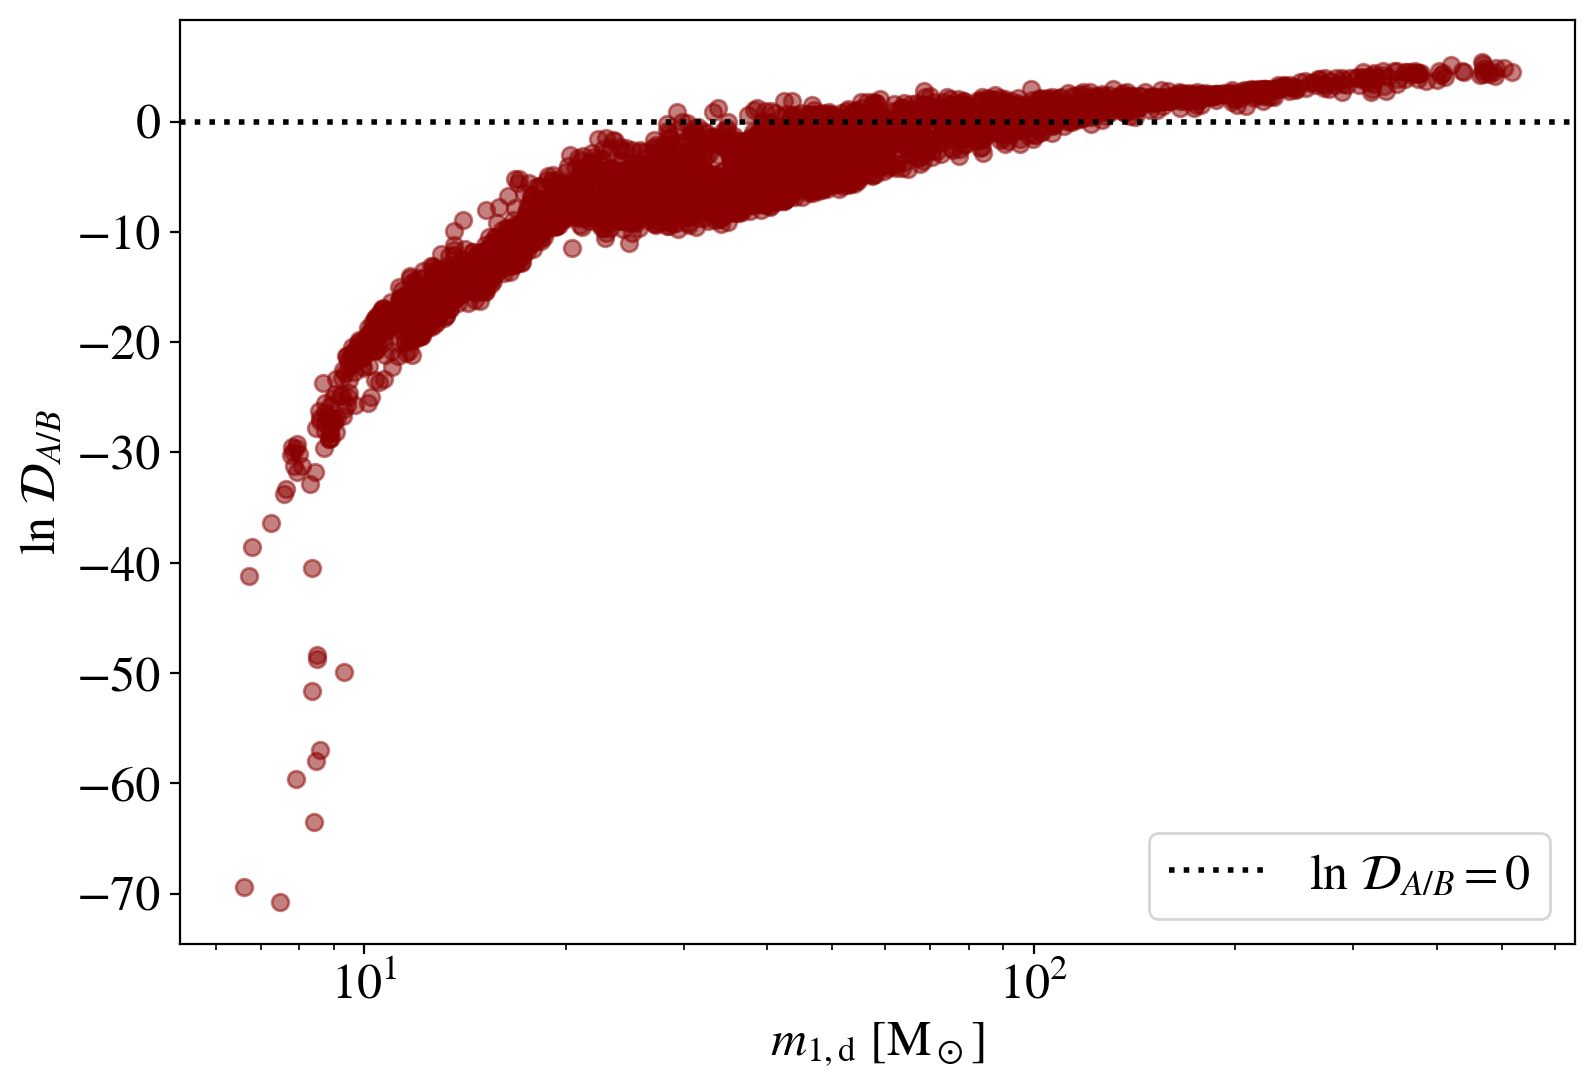

In [19]:
print(medians_arr_PopI.shape)
plt.figure(figsize=(9,6))
plt.plot(medians_arr_PopI[:,0], bayes_ratios_nopriors_PopI, lw = 0, marker = 'o', alpha = 0.5, color = 'darkred')

# detections with log bayes ratio >= 5 are extremely likely to be Pop. I
# all of these detections are Pop. I
# therefore all the detections with log bayes ratio <= 5 are wronlgy classified
print('number of misclassified sources = ', 
      len(np.nonzero((np.array(bayes_ratios_nopriors_PopI) <= 5))[0]))

plt.xlabel(r'$m_{1,\mathrm{d}}$ [M$_\odot$]', fontsize = font_value)
plt.ylabel(r'ln $\mathcal{D}_{A/B}$', fontsize = font_value)
plt.xscale('log')
# Plotting the horizontal line
plt.axhline(y=0, color='black', lw = 2, linestyle=':', label = 'ln $\mathcal{D}_{A/B} = 0$')

plt.legend()

plt.show()

In [20]:
if skip == False:
    # load posterior samples of  Pop. III detections
    path_to_file = '../test_catalogs_v1/test_cat_Pop.III_fiducial_0.3_10yr_WithPhysicalPriors.h5'
    f1_PopIII = h5py.File(path_to_file,'r')  
    
    num_sam = len(np.array(f1_PopIII['instance_0']['samples'][0]))
    print('number of samples per each detection = ', num_sam)
    
    #index_subsample = np.arange(len(f1_PopIII.keys()))
    #index_subsample = np.arange(10_000, 11_300)
    #index_subsample = np.random.choice(np.arange(len(f1_PopIII.keys())),139)
    index_subsample = np.loadtxt('../clf_plots_v9/indices_to_use_Pop.III_fiducial_0.3.txt').astype(int)
    print('number of detections = ', index_subsample)
    
    bayes_ratios_nopriors_PopIII = []
    medians_arr_PopIII = np.zeros((len(index_subsample),3))
    # You have everything the evaluate the bayes ratio 
    for i_c, i in (enumerate(tqdm(index_subsample, disable = False))):
        #print('detection = ', i)
        #ind_test = np.random.choice(np.arange(num_sam),200)
        X_test = np.transpose(f1_PopIII['instance_'+str(i)]['samples'])#[ind_test,:]
        ## log x        
        X_test_dict_log = {'mass_1': np.log(X_test[:,0]), 
                      'mass_2': np.log(X_test[:,1]), 
                      'luminosity_distance': np.log(X_test[:,2])}
        X_test_kde_log = pd.DataFrame(X_test_dict_log)
        #print(X_test_kde)
        #print(X_test.shape)

        ## x
        #X_test_dict = {'mass_1': X_test[:,0], 
        #      'mass_2': X_test[:,1], 
        #      'luminosity_distance': X_test[:,2]}
        #X_test_kde= pd.DataFrame(X_test_dict)
    
        priors_array = [
            uniform_pdf(X_test[:,0], min_m1, max_m1),
            uniform_pdf(X_test[:,1], min_m2, X_test[:,0]),
            uniform_in_differential_comoving_volume_pdf(
                X_test[:,2], 
                min_z, 
                max_z, 
                np.interp(X_test[:,2], 
                          dd, 
                          zz), norm_factor)] 
    
        priors_prod = np.prod(priors_array, axis = 0)
        #print('priors_prod = ', priors_prod)
        
        ## log x
        kde_result_PopIII = kde_PopIII.score_samples(X_test_kde_log)
        ## x
        #kde_result_PopIII = kde_PopIII.score_samples(X_test_kde)
        posterior_ratio_PopIII = np.log(np.sum(
                    np.exp(kde_result_PopIII-np.log(priors_prod)
                          )))
        #print('posterior_ratio_PopIII = ', posterior_ratio_PopIII)
    
        ## log x
        kde_result_PopI = kde_PopI.score_samples(X_test_kde_log)
        ##  x
        #kde_result_PopI = kde_PopI.score_samples(X_test_kde)
        posterior_ratio_PopI = np.log(np.sum(
                    np.exp(kde_result_PopI-np.log(priors_prod)
                          )))
        #print('posterior_ratio_PopI = ', posterior_ratio_PopI)
    
        bayes_ratio_nopriors = np.log(p_det_PopI) - np.log(p_det_PopIII) + posterior_ratio_PopIII - posterior_ratio_PopI
    
        #print('bayes_ratio_nopriors = ', bayes_ratio_nopriors)    
        bayes_ratios_nopriors_PopIII.append(bayes_ratio_nopriors)
        medians = np.median(X_test, axis = 0)
        medians_arr_PopIII[i_c,:] = medians

number of samples per each detection =  1000
number of detections =  [ 61 421 223 340 423 191  52 173 342 299 305 387 263 360 440 442 125 149
  14 249 275 260 262 184 347 370 168 129 291  39  50 361 431  38 306 151
 422 101  25 156 403  91 343 169 432  79 329 446 455 336 354  99  64 222
 330  48 365 208   4  69 318  73 108 159  22 200 325 441 195 416 433 250
 102 226 227 271 321 424 353 280 369  13 257 258  20  10 350 461 390 188
 395 317 259 332 246  28  35 296 279 219 301 132 284 134 411 363 122 351
   3  63 339 128 216 206 161 352 180  33  76 210 240 220  72  45 148 384
 104 133 313 118 112 190  96 451 320 452 166 372 261]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:54<00:00,  2.57it/s]


In [21]:
if skip == False:   
    np.savetxt('bayes_ratio_PopIII_rtol_inv_log.txt', np.transpose([medians_arr_PopIII[:,0],medians_arr_PopIII[:,1],medians_arr_PopIII[:,2], bayes_ratios_nopriors_PopIII]),
          header = 'med_mass_1 med_mass_2 med_lum_dist log_D_AB', comments = '')
elif skip == True:
    medians_arr_PopIII = np.transpose(np.loadtxt('bayes_ratio_PopIII_rtol_inv.txt', skiprows = 1, unpack = True, usecols = [0,1,2]))
    bayes_ratios_nopriors_PopIII = np.loadtxt('bayes_ratio_PopIII_rtol_inv.txt', skiprows = 1, unpack = True, usecols = [3])

number of misclassified sources =  139


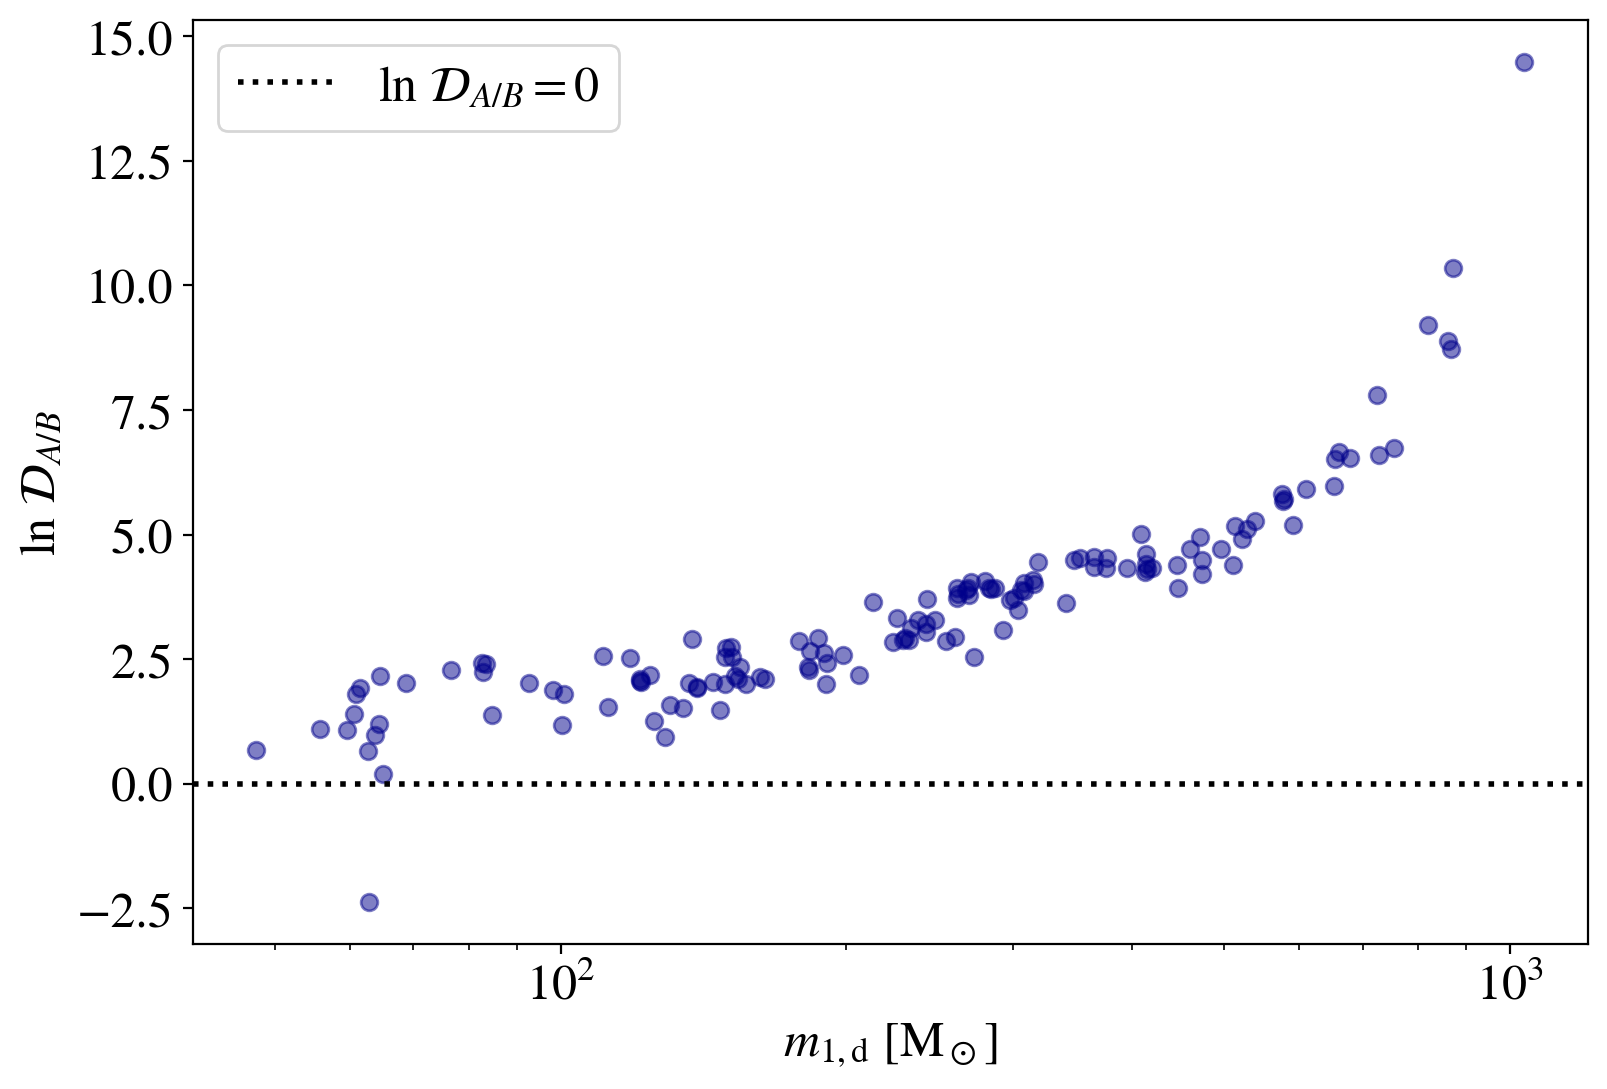

In [22]:
plt.figure(figsize=(9,6))
plt.plot(medians_arr_PopIII[:,0], bayes_ratios_nopriors_PopIII, lw = 0, marker = 'o', alpha = 0.5, color = 'darkblue')
#plt.ylim([-5,5])

# detections with log bayes ratio <= -5 are likely to be Pop. III
# all of these detections are Pop. III
# therefore all the detections with log bayes ratio >= -5 are wronlgy classified
print('number of misclassified sources = ', 
      len(np.nonzero((np.array(bayes_ratios_nopriors_PopIII) >= -5))[0]))

plt.xlabel(r'$m_{1,\mathrm{d}}$ [M$_\odot$]', fontsize = font_value)
plt.ylabel(r'ln $\mathcal{D}_{A/B}$', fontsize = font_value)
plt.xscale('log')

# Plotting the horizontal line
plt.axhline(y=0, color='black', lw = 2, linestyle=':', label = 'ln $\mathcal{D}_{A/B} = 0$')

plt.legend()


plt.show()

In [23]:
N3 = 140
N2 = 3420
log_prior_PopIII = np.log(N3)
log_prior_PopI = np.log(N2)


In [24]:
def apply_prior(p, N3, N2):
    """
    This function converts from $p(j \in k|\mathbf{x}, d_j)$ to $p(j \in k|\mathbf{x}, d_j, \{β\})$.
    
    Parameters:
    - p: Probability extracted from the classifier using the method predict_proba.
    - N3: Number of Pop. III BBHs.
    - N2: Number of Pop. I-II BBHs.
    
    Returns:
    - p_post: Probability corrected for imbalance.
    """
    #Q = p/(1-p)*N3/N2
    # changed as now is in the paper
    p_post = (p*N3)/(p*(N3-N2)+N2)

    return p_post #Q/(1+Q)

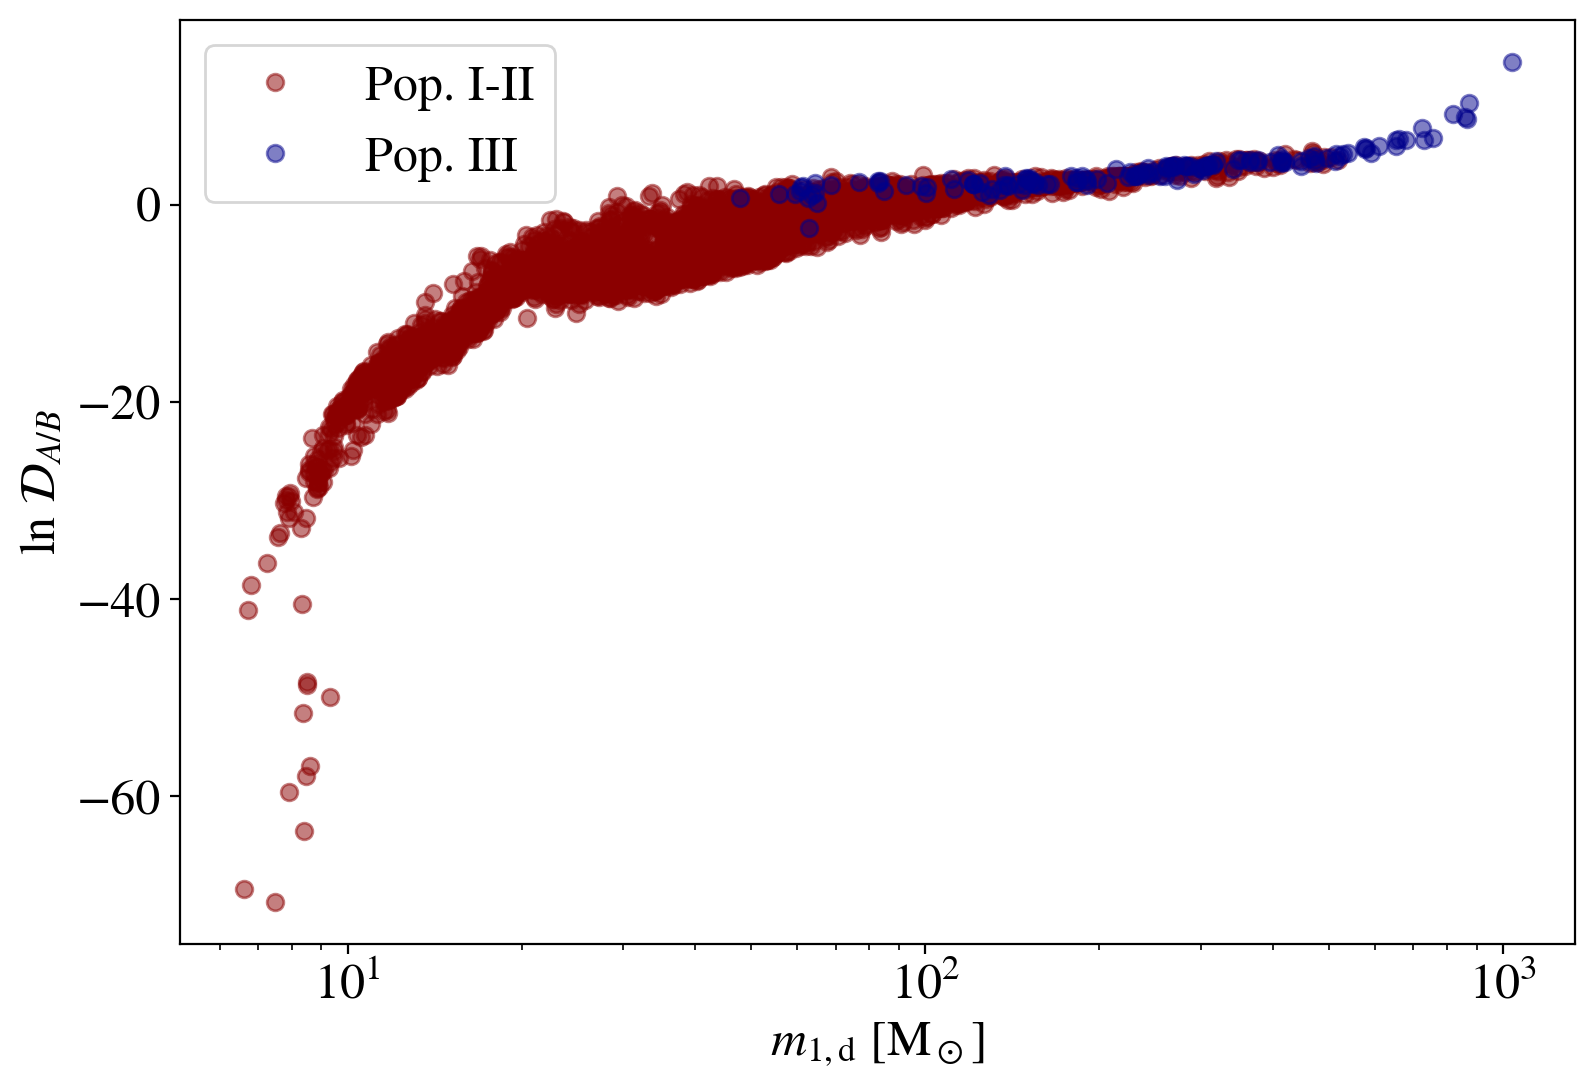

In [25]:
plt.figure(figsize=(9,6))


plt.plot(medians_arr_PopI[:,0], bayes_ratios_nopriors_PopI, lw = 0, marker = 'o', alpha = 0.5, color = 'darkred',
        label = 'Pop. I-II')
plt.plot(medians_arr_PopIII[:,0], bayes_ratios_nopriors_PopIII, lw = 0, marker = 'o', alpha = 0.5, color = 'darkblue',
        label = 'Pop. III')

plt.xlabel(r'$m_{1,\mathrm{d}}$ [M$_\odot$]', fontsize = font_value)
plt.ylabel(r'ln $\mathcal{D}_{A/B}$', fontsize = font_value)

plt.xscale('log')

plt.legend()


plt.show()

In [26]:
# TP are only those sources correclty classified 
TP = np.sum(np.array(bayes_ratios_nopriors_PopIII) >= 0)
# FN are all those sources incorreclty classified 
FN = np.sum(np.array(bayes_ratios_nopriors_PopIII) <= 0)

# TN are only those sources correclty classified as Pop. I
TN = np.sum(np.array(bayes_ratios_nopriors_PopI) <= 0)
# FP are all those sources incorreclty classified as Pop. III
FP = np.sum(np.array(bayes_ratios_nopriors_PopI) >= 0)

precision = TP/(TP+FP)
print('precision = ', precision)

recall = TP/(TP+FN)
print('recall = ', recall)

# threshold must be the same?


precision =  0.17624521072796934
recall =  0.9928057553956835


In [27]:
medians_arr_PopI_xg = np.transpose(np.loadtxt('../clf_plots_v9/p_PopIII_PopI.txt', skiprows = 1, unpack = True, usecols = [0,1,2]))
p_PopI_xg = np.loadtxt('../clf_plots_v9/p_PopIII_PopI.txt', skiprows = 1, unpack = True, usecols = [3])

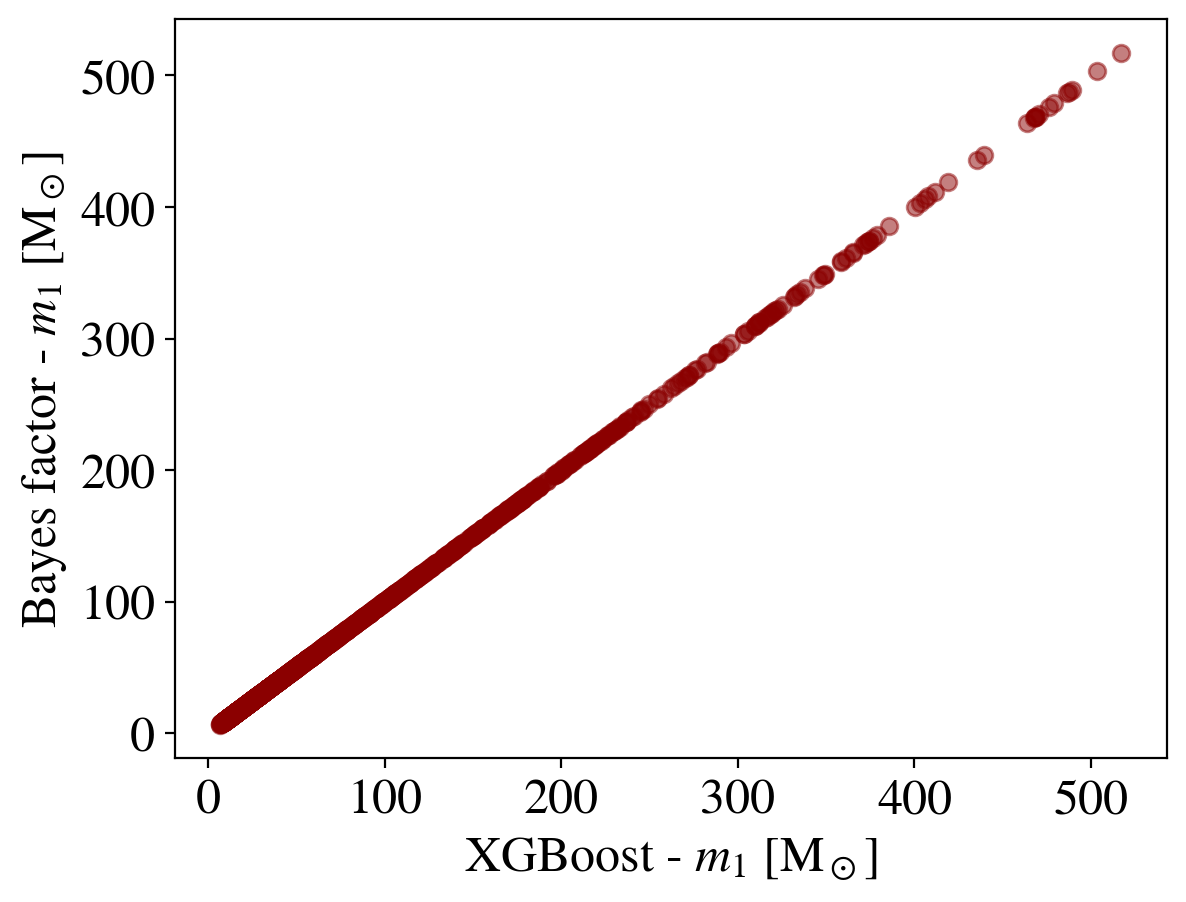

In [28]:
plt.plot(medians_arr_PopI_xg[:,0],
        medians_arr_PopI[:,0], lw = 0, marker = 'o', color ='darkred', alpha = 0.5)
plt.xlabel('XGBoost - $m_1$ [M$_\odot$]')
plt.ylabel('Bayes factor - $m_1$ [M$_\odot$]')
plt.show()

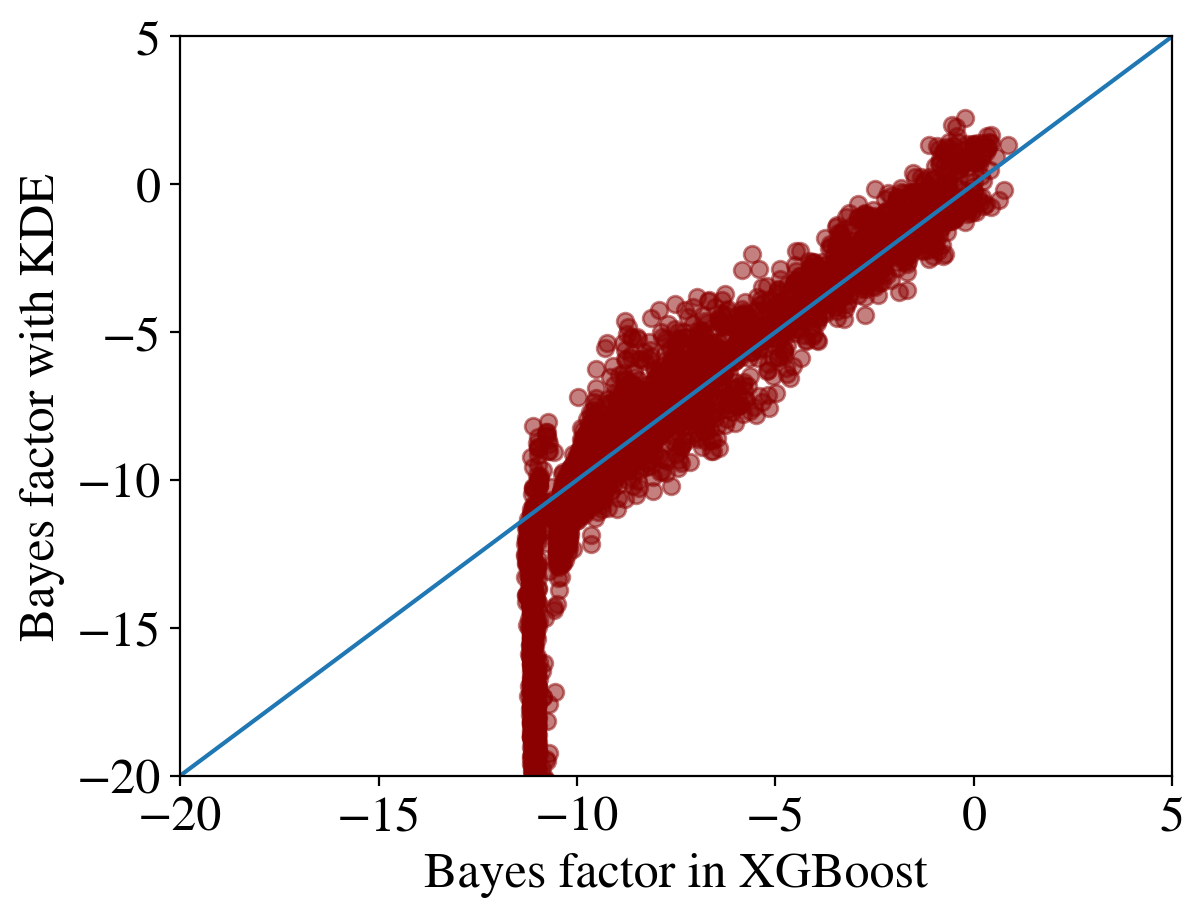

In [29]:
#print(np.array(bayes_ratios_nopriors_PopI + log_prior_A - log_prior_B))

#print(np.log(p_PopI_xg/(1-p_PopI_xg)))

bayes_ratios_PopI_xg = np.log(apply_prior(p_PopI_xg,N3,N2)/(1-apply_prior(p_PopI_xg,N3,N2)))

plt.plot(bayes_ratios_PopI_xg,
         np.array(bayes_ratios_nopriors_PopI + log_prior_PopIII - log_prior_PopI), lw = 0, marker = 'o',
        color = 'darkred', alpha = 0.5)

#plt.plot(bayes_ratios_PopI_xg,
#         np.array(bayes_ratios_nopriors_PopI), lw = 0, marker = 'o',
#        color = 'darkred', alpha = 0.5)

x = np.linspace(-20,5,100)
plt.plot(x,x)

plt.xlim([-20,5])
plt.ylim([-20,5])

plt.xlabel('Bayes factor in XGBoost')
plt.ylabel('Bayes factor with KDE')

plt.show()

In [30]:
medians_arr_PopIII_xg = np.transpose(np.loadtxt('../clf_plots_v9/p_PopIII_fiducial.txt', skiprows = 1, unpack = True, usecols = [0,1,2]))
p_PopIII_xg = np.loadtxt('../clf_plots_v9/p_PopIII_fiducial.txt', skiprows = 1, unpack = True, usecols = [3])


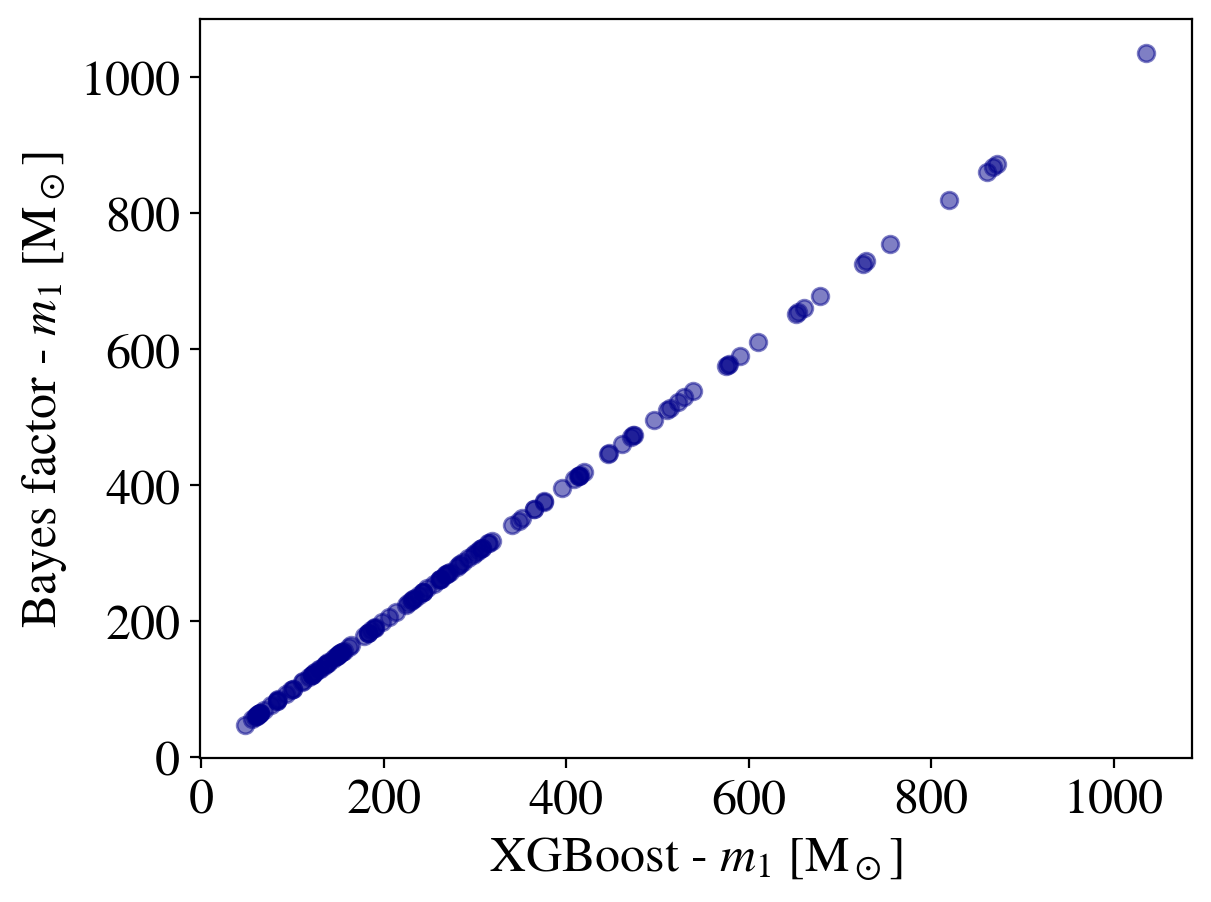

In [31]:
plt.plot(medians_arr_PopIII_xg[:,0],
        medians_arr_PopIII[:,0], lw = 0, marker = 'o', color ='darkblue', alpha = 0.5)
plt.xlabel('XGBoost - $m_1$ [M$_\odot$]')
plt.ylabel('Bayes factor - $m_1$ [M$_\odot$]')
plt.show()

In [32]:
bayes_ratios_PopIII_xg = np.log(apply_prior(p_PopIII_xg,N3,N2)/(1-apply_prior(p_PopIII_xg,N3,N2)))


-5.0 0.130558183538316 0.1393939393939394
-4.898989898989899 0.13282001924927817 0.1419753086419753
-4.797979797979798 0.13463414634146342 0.14345114345114346
-4.696969696969697 0.1377245508982036 0.1461864406779661
-4.595959595959596 0.13995943204868155 0.148068669527897
-4.494949494949495 0.14241486068111456 0.1495124593716143
-4.393939393939394 0.1440501043841336 0.15148188803512624
-4.292929292929293 0.1464968152866242 0.15453527435610304
-4.191919191919192 0.1490280777537797 0.15664018161180476
-4.090909090909091 0.1511500547645126 0.15916955017301038
-3.9898989898989896 0.15384615384615385 0.16216216216216217
-3.888888888888889 0.15628539071347677 0.16546762589928057
-3.787878787878788 0.15898617511520738 0.16727272727272727
-3.686868686868687 0.16121495327102803 0.16974169741697417
-3.5858585858585856 0.16292798110979928 0.17271589486858574
-3.484848484848485 0.16646562123039807 0.17579617834394903
-3.383838383838384 0.16995073891625614 0.17992177314211213
-3.282828282828283 0.1

/var/folders/25/1qjd4ptd4vdd80rrx8p7b9lr0000gp/T/ipykernel_7841/2208464285.py:53: RuntimeWarning: invalid value encountered in long_scalars
  precision_xg = TP/(TP+FP)


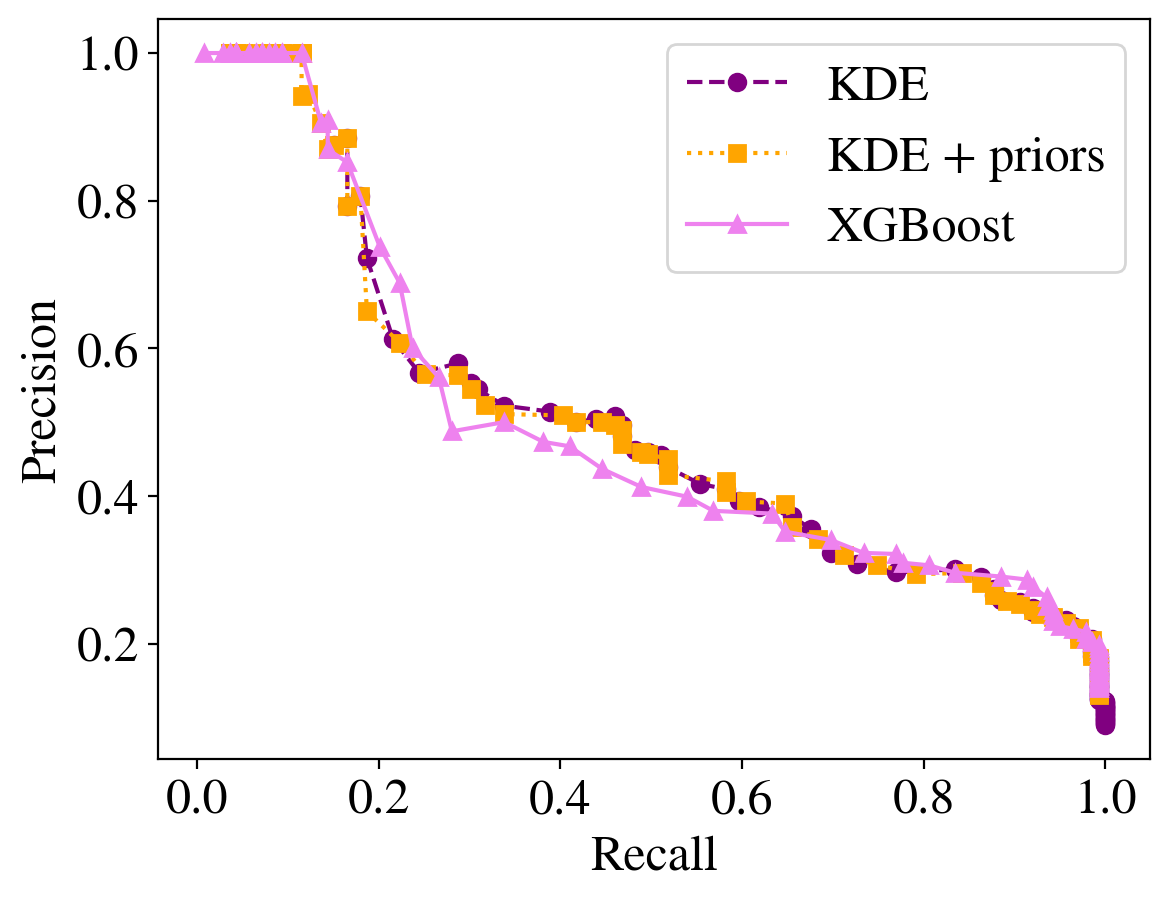

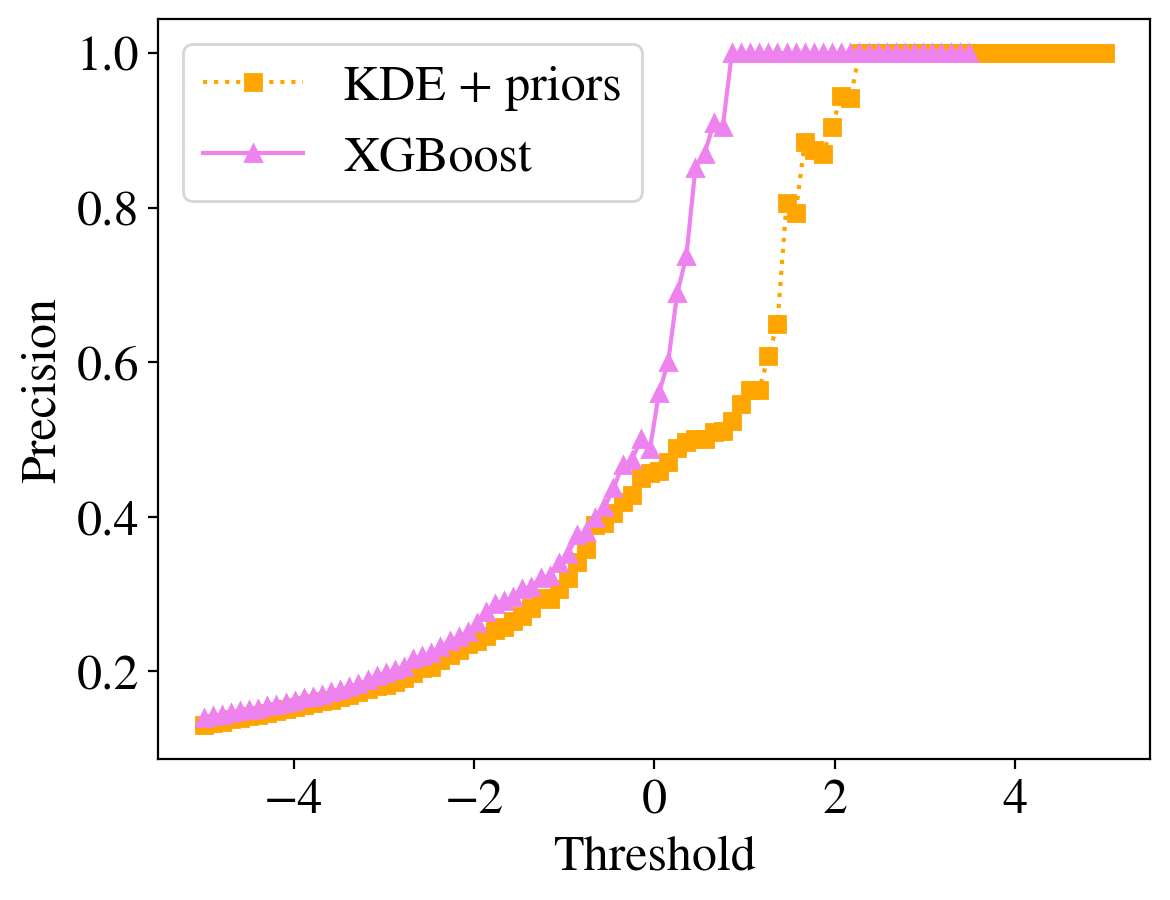

In [33]:
# Assuming y_true contains the true labels and y_pred contains the predicted probabilities
# of the positive class
precision_curve_noprior = []
recall_curve_noprior = [] 


precision_curve_prior = []
recall_curve_prior = [] 

precision_curve_prior_int = []
recall_curve_prior_int = [] 

precision_curve_xgboost = []
recall_curve_xgboost = [] 

thresholds = np.linspace(-5,5,100)

for t in thresholds:

    TP = np.sum(np.array(bayes_ratios_nopriors_PopIII) >= t)
    FN = np.sum(np.array(bayes_ratios_nopriors_PopIII) <= t)
    TN = np.sum(np.array(bayes_ratios_nopriors_PopI) <= t)
    FP = np.sum(np.array(bayes_ratios_nopriors_PopI) >= t)
    precision = TP/(TP+FP)
    precision_curve_noprior.append(precision)
    recall = TP/(TP+FN)
    recall_curve_noprior.append(recall)

    TP = np.sum(np.array(bayes_ratios_nopriors_PopIII + log_prior_PopIII - log_prior_PopI) >= t)
    FN = np.sum(np.array(bayes_ratios_nopriors_PopIII + log_prior_PopIII - log_prior_PopI) <= t)
    TN = np.sum(np.array(bayes_ratios_nopriors_PopI + log_prior_PopIII - log_prior_PopI) <= t)
    FP = np.sum(np.array(bayes_ratios_nopriors_PopI + log_prior_PopIII - log_prior_PopI) >= t)
    precision_kde = TP/(TP+FP)
    precision_curve_prior.append(precision_kde)
    recall = TP/(TP+FN)
    recall_curve_prior.append(recall)

    """
    TP = np.sum(np.array(bayes_ratios_nopriors_PopIII + log_prior_PopIII_int- log_prior_PopI_int) >= t)
    FN = np.sum(np.array(bayes_ratios_nopriors_PopIII + log_prior_PopIII_int - log_prior_PopI_int) <= t)
    TN = np.sum(np.array(bayes_ratios_nopriors_PopI + log_prior_PopIII_int - log_prior_PopI_int) <= t)
    FP = np.sum(np.array(bayes_ratios_nopriors_PopI + log_prior_PopIII_int - log_prior_PopI_int) >= t)
    precision = TP/(TP+FP)
    precision_curve_prior_int.append(precision)
    recall = TP/(TP+FN)
    recall_curve_prior_int.append(recall)
    """
    
    TP = np.sum(np.array(bayes_ratios_PopIII_xg) >= t)
    FN = np.sum(np.array(bayes_ratios_PopIII_xg) <= t)
    TN = np.sum(np.array(bayes_ratios_PopI_xg) <= t)
    FP = np.sum(np.array(bayes_ratios_PopI_xg) >= t)
    precision_xg = TP/(TP+FP)
    precision_curve_xgboost.append(precision_xg)
    recall = TP/(TP+FN)
    recall_curve_xgboost.append(recall)
    print(t, precision_kde, precision_xg)

# Plot the precision-recall curve
plt.plot(recall_curve_noprior, precision_curve_noprior, marker='o', ls = '--', label = 'KDE', color = 'purple')
plt.plot(recall_curve_prior, precision_curve_prior, marker='s', ls = ':', label = 'KDE + priors', color = 'orange')
#plt.plot(recall_curve_prior_int, precision_curve_prior_int, marker='s', ls = ':', label = 'KDE + int priors')
plt.plot(recall_curve_xgboost, precision_curve_xgboost, marker='^', ls = 'solid', label = 'XGBoost', color = 'violet')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.plot(thresholds, precision_curve_prior, marker='s', ls = ':', label = 'KDE + priors', color = 'orange')
plt.plot(thresholds, precision_curve_xgboost, marker='^', ls = 'solid', label = 'XGBoost', color = 'violet')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.legend()
plt.show()